# Variography

The aim of this practical session is to manipulate the variography utilities from the *gstlearn* package.

## I - Load Packages and data

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp

We start by loading the data and the prediction grid

In [35]:
# Dataset

import minigst as mg

jura_all, grid, _ = mg.data("Jura")

Separate the data set in two sets : the training set and the validation set.
For the project and the Kaggle competition, you should use the full data set for 
the training.
You will submit your prediction on Kaggle for a set of locations on which you will 
only know the locations and the factors of Land Use and Rock at these locations.

In [36]:
ntot = jura_all.shape[0]
ntrain = 200
nval = ntot - ntrain

indtrain = np.random.choice(ntot, ntrain).astype(int)
indval = np.setdiff1d(np.arange(ntot), indtrain)

jura = jura_all.loc[indtrain, :]

# val contains the values to predict. For the project, these values will be on Kaggle
# (for other locations) and you won't know them
# You will have the locations and covariables at the unknown locations by the following command :
val_loc = jura_all.loc[indval, ["Xloc", "Yloc", "Landuse", "Rock"]]
val = jura_all.loc[indval, ["Co"]]

## II - Omnidirectional variogram (Do It Yourself)



### 1) Compute the variogram cloud
 
 Create a vector (or a matrix) *dist* containing all the distances between the points and a vector (or a matrix) *vario* containing the variogram values given by

 $\frac{1}{2}(z(x_i)-z(x_j))^2$ 
 
 for all the pairs of points $i$ and $j$, and where $z$ stands for the Cobalt grade at a given location.
 
 


 
 Hint: The *np.ufunc.outer*  function (where *ufunc* should be replaced by the name of an operator) takes as an input two vectors a and b, and returns a matrix whose entry (i,j) contains the quantity ufunc(a[i],b[j]). See examples below:

In [37]:
np.add.outer([1, 2, 3], [4, 5, 6])

array([[5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

In [38]:
np.subtract.outer([1, 2, 3], [4, 5, 6])

array([[-3, -4, -5],
       [-2, -3, -4],
       [-1, -2, -3]])

In [39]:
np.multiply.outer([1, 2, 3], [4, 5, 6])

array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])

Solution:

In [40]:
jura = jura_all

## Distance matrix
dist = (
    np.subtract.outer(jura["Xloc"].to_numpy(), jura["Xloc"].to_numpy()) ** 2
    + np.subtract.outer(jura["Yloc"].to_numpy(), jura["Yloc"].to_numpy()) ** 2
) ** 0.5

## Variogram values
vario = 0.5 * np.subtract.outer(jura["Co"].to_numpy(), jura["Co"].to_numpy()) ** 2

Display the result as a scatter plot Distance VS Variogram value

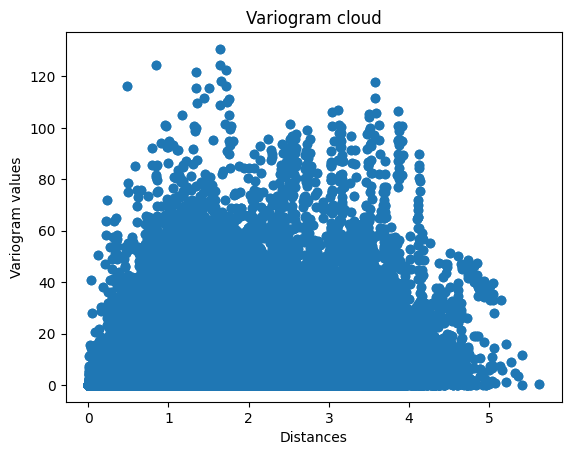

In [41]:
## Plot variogram cloud
plt.scatter(dist.flatten(), vario.flatten())
plt.xlabel("Distances")
plt.ylabel("Variogram values")
plt.title("Variogram cloud")
plt.show()

In [42]:
np.subtract.outer(jura["Xloc"].to_numpy(), jura["Xloc"].to_numpy())

array([[ 0.   , -0.158, -0.421, ..., -1.684, -2.224, -1.219],
       [ 0.158,  0.   , -0.263, ..., -1.526, -2.066, -1.061],
       [ 0.421,  0.263,  0.   , ..., -1.263, -1.803, -0.798],
       ...,
       [ 1.684,  1.526,  1.263, ...,  0.   , -0.54 ,  0.465],
       [ 2.224,  2.066,  1.803, ...,  0.54 ,  0.   ,  1.005],
       [ 1.219,  1.061,  0.798, ..., -0.465, -1.005,  0.   ]])

### 2) Compute the experimental variogram

Complete the following function aiming at computing an experimental variogram based on a distance matrix and on a variogram matrix

In [43]:
## Inputs:
##### hbins : Vector defining the limits of the distance bins at which the variogram values are averaged
##### dist : Matrix of distances between every pair of points
##### vario : Matrix of variogram values between every pair of points
## Output
##### Matrix whose first column contains the center of each bin, and second contains the variogram value at each bin, and third contains the number of points in each bin


def variogram(hbins, dist, vario):
    ## Flatten the distance and variogram matrices
    dist_vec = dist.flatten()
    vario_vec = vario.flatten()

    ## Output
    res = np.zeros((len(hbins) - 1, 3))

    ## Loop over lags
    for i in range(len(hbins) - 1):
        ## Center of the bin
        h = (hbins[i + 1] + hbins[i]) / 2
        res[i, 0] = h

        ## Find the pair of points with a distance within the bin
        ind_sel = (dist_vec > hbins[i]) * (dist_vec <= hbins[i + 1]) == 1

        ## Compute the corresponding variogram value
        res[i, 1] = np.mean(vario_vec[ind_sel])

        ## Number of points used
        res[i, 2] = len(vario_vec[ind_sel]) / 2

    return res

Plot the result

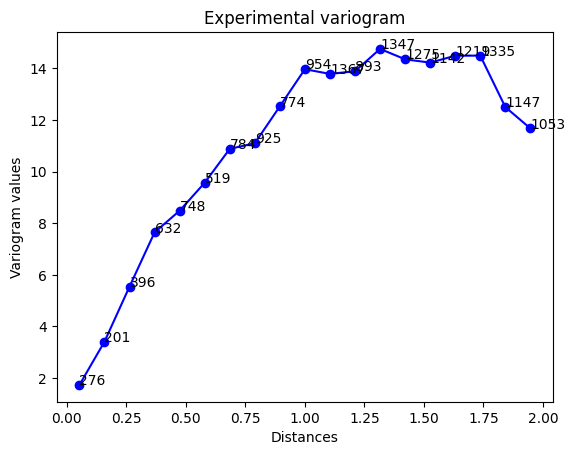

In [44]:
## Define vector of Lags
hmax = 2
nbins = 20
hbins = np.linspace(0, hmax, nbins)

## Compute variogram
vg = variogram(hbins, dist, vario)

## Plot result
plt.plot(vg[:, 0], vg[:, 1], "-bo")
for i in range(vg.shape[0]):
    plt.text(vg[i, 0], vg[i, 1], int(vg[i, 2]))
plt.xlabel("Distances")
plt.ylabel("Variogram values")
plt.title("Experimental variogram")
plt.show()

### 3) Fit with an exponential model

#### a - Create a function that evaluates the exponential variogram model at a given lag

In [45]:
## Inputs:
##### h : Lag value (or vector)
##### sill : Variogram sill parameter
##### scale : Variogram scale parameter
## Output
##### Value of the exponential variogram model at lag h


def vexp(h, sill, scale):
    return sill * (1 - np.exp(-h / scale))

#### b - Try to fit the experimental variogram with an exponential model manually

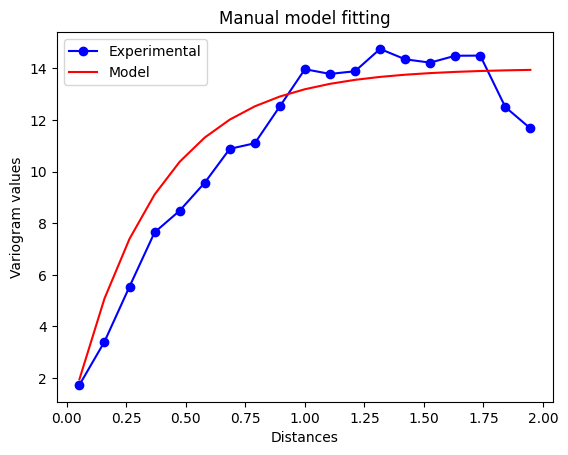

In [46]:
## Try out some parameters:
sill_test = 14
scale_test = 0.35

## Plot result
plt.plot(vg[:, 0], vg[:, 1], "-bo", label="Experimental")
plt.plot(vg[:, 0], vexp(vg[:, 0], sill_test, scale_test), color="red", label="Model")
plt.xlabel("Distances")
plt.ylabel("Variogram values")
plt.legend()
plt.title("Manual model fitting")
plt.show()

### c - Fit the experimental variogram automatically using an optimization algorithm to minimize the sum of squared errors between the experimental variogram values and the model.

Hint: Use the function *minimize* from the *scipy.optimize* package

Optimal sill 14.481085618611303
Optimal scale 0.48434621749263956


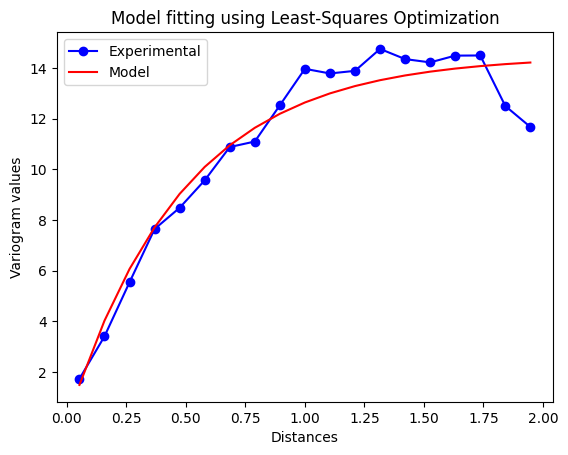

In [47]:
from scipy.optimize import minimize


## For a given value of sill and of range (stored in a vector param), compute the sum of squared errors between the experimental variogram and the model
def cost_func(param):
    sill = param[0]
    scale = param[1]
    return ((vexp(vg[:, 0], sill, scale) - vg[:, 1]) ** 2).sum()


## Optimize
param_init = [0.45, 10]  ## Initial guesses for the sill and range paramters
res = minimize(cost_func, param_init)

## Extract results
sill_opt = res.x[0]
scale_opt = res.x[1]
print("Optimal sill", sill_opt)
print("Optimal scale", scale_opt)


## Plot result
plt.plot(vg[:, 0], vg[:, 1], "-bo", label="Experimental")
plt.plot(vg[:, 0], vexp(vg[:, 0], sill_opt, scale_opt), color="red", label="Model")
plt.xlabel("Distances")
plt.ylabel("Variogram values")
plt.legend()
plt.title("Model fitting using Least-Squares Optimization")
plt.show()

## Using minigst 
(and possibly gstlearn)

In [48]:
import minigst as mg
import gstlearn.plot as gp
import pandas as pd
import gstlearn as gl
# Dataset
# jura=pd.read_csv("jura/jura_pred.csv")

### 0) Create database

Turn the Pandas dataframe 'jura' into a gstlearn database by applying function *Db_fromPanda* to the dataframe.

In [49]:
## Create databse
db_jura = mg.df_to_db(jura, coord_names=["Xloc", "Yloc"])

In [50]:
## Display databse
db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 11
Total number of samples      = 259

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Cd - Locator = NA
Column = 5 - Name = Co - Locator = NA
Column = 6 - Name = Cr - Locator = NA
Column = 7 - Name = Cu - Locator = NA
Column = 8 - Name = Ni - Locator = NA
Column = 9 - Name = Pb - Locator = NA
Column = 10 - Name = Zn - Locator = NA


### 1) Experimental variogram

To compute an (omnidirectional) experimental variogram, we start by creating a VarioParam object containing the parameters of the variogram. This is done using the function VarioParam_createOmniDirection. We can specify the number of lags h for which the experimental variogram is computed (argument npas), and the distance between these lags (argument dpas), as well as the tolerance τ on the lags (argument toldis).


Then, the experimental variogram is computed in two steps. First, a Vario object is initialized from the VarioParam object and the Db containing the data points. 


In [51]:
## Create experimental variogram object with specified parameters
varioexp = mg.vario_exp(db_jura, vname="Co", nlag=30, dlag=0.1, toldis=0.5)

We can then plot the experimental variogram using the *gstlearn.plot* function *plot*.

<Axes: >

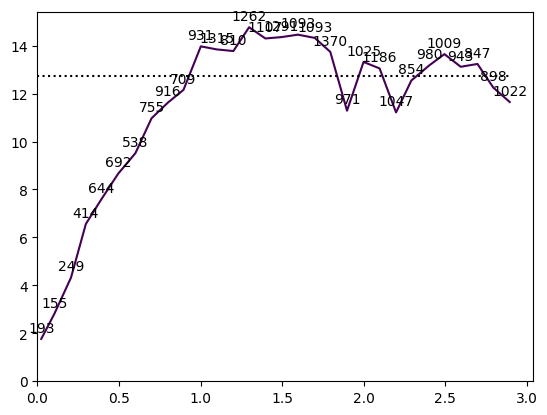

In [52]:
gp.plot(varioexp, showPairs=True)

### 2) Automatic model fitting



Fitting a variogram model on an experimental variogram is done in two steps. 



First, we create Model object. These objects aim at containing all the necessary information about the covariance structure of a random field. In particular, it is assumed that this covariance structure is a superposition of basic elementary covariance structures: the Model objects then contains the covariance types and parameters of each one of these basic covariance structures.



In [53]:
struct_names = ["NUGGET", "EXPONENTIAL"]

# isotropic case
model_iso = mg.model_fit(varioexp, struct=struct_names)

<Axes: >

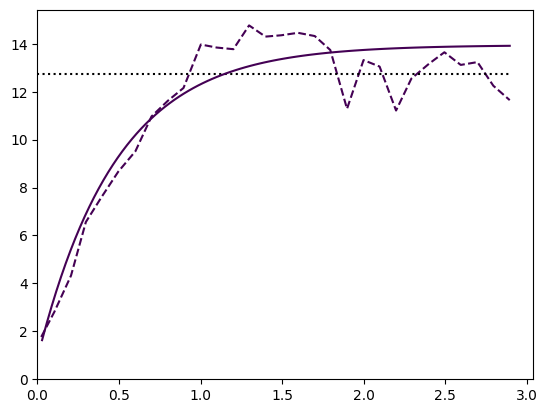

In [54]:
gp.varmod(varioexp, model_iso)

In [55]:
model_iso


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         =      0.869
Exponential
- Sill         =     13.078
- Range        =      1.442
- Theo. Range  =      0.481
Total Sill     =     13.947
Known Mean(s)     0.000

As we can see, only one basic covariance structure is used to define the model (namely, a Spherical covariance function whose range and sill are printed).

We then plot both the experimental variogram and the variogram model resulting from the fitting using the plot.varmod function. In the figure we obtain, In the figure above, the dashed blue line corresponds to the experimental variogram, and the solid blue line corresponds to the fitted variogram model.

It is also possible to guide the model fitting by proposing a list of basic covariance structures from which the model is to be built. The list of available basic covariance structures is obtained by running the following command:


In [56]:
gl.ECov.printAll()

  -2 -     UNKNOWN : Unknown covariance
  -1 -    FUNCTION : External covariance function
   0 -      NUGGET : Nugget effect
   1 - EXPONENTIAL : Exponential
   2 -   SPHERICAL : Spherical
   3 -    GAUSSIAN : Gaussian
   4 -       CUBIC : Cubic
   5 -     SINCARD : Sine Cardinal
   6 -     BESSELJ : Bessel J
   7 -      MATERN : Matern
   8 -       GAMMA : Gamma
   9 -      CAUCHY : Cauchy
  10 -      STABLE : Stable
  11 -      LINEAR : Linear
  12 -       POWER : Power
  13 -   ORDER1_GC : First Order Generalized covariance
  14 -   SPLINE_GC : Spline Generalized covariance
  15 -   ORDER3_GC : Third Order Generalized covariance
  16 -   ORDER5_GC : Fifth Order Generalized covariance
  17 -     COSINUS : Cosine
  18 -    TRIANGLE : Triangle
  19 -      COSEXP : Cosine Exponential
  20 -       REG1D : 1-D Regular
  21 -       PENTA : Pentamodel
  22 -  SPLINE2_GC : Order-2 Spline
  23 -     STORKEY : Storkey covariance in 1-D
  24 -   WENDLAND0 : Wendland covariance (2,0)
  25 -   WE

In practice, we start by creating a list of basic structures using the ECov_fromKeys function which we supply with a vector containing the names of the basic structures we would like to see in the model. To fit the model, we then once again call the fit method and supply it with both the experimental variogram and the newly created list of basic structures (argument types). Then the fitting procedures tries find the composition of models from the supplied list that best fits the experimental variogram.

Note that by default, the fitting algorithm tries to be parsimonious and can therefore "drop" some of the structures that we supply if it deems that a model with less structures provides a better fit. To force the fitting algorithm to keep all the structures from the list, we simply need to add the argument optvar=Option_VarioFit(TRUE) to the fit method.

In the next example, we once again define a model by fitting it on our experimental variogram. But this time, we specify that we want the resulting model to be a composition of basic structures restricted to these choices: a Nugget effect, a Cubic covariance and a Spherical covariance.

In [57]:
## Fit model on experimental variogram
types = ["NUGGET", "CUBIC", "EXPONENTIAL"]
model_iso = mg.model_fit(varioexp, struct=types)

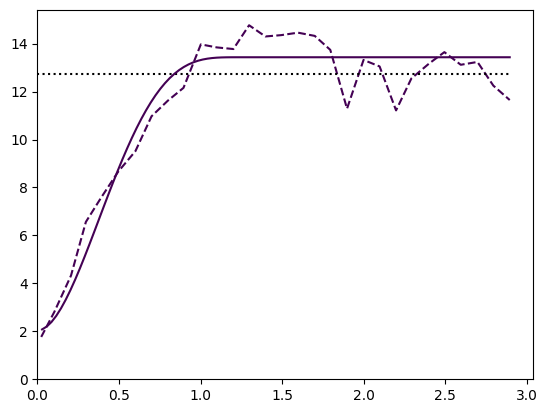

In [58]:
ax = gp.varmod(varioexp, model_iso)

### 3) Variogram maps and directional variograms

The experimental variogram map is a map centered at the origin, which represents the value of experimental directional variogram across all directions 0∘≤θ<360∘. This tool can be used to identify potential anistropies in the data.

To compute an experimental variogram map, we use the function db_vmap_compute which we supply with the Db containing the data. The output is a Db containing a grid representing the variogram map values.

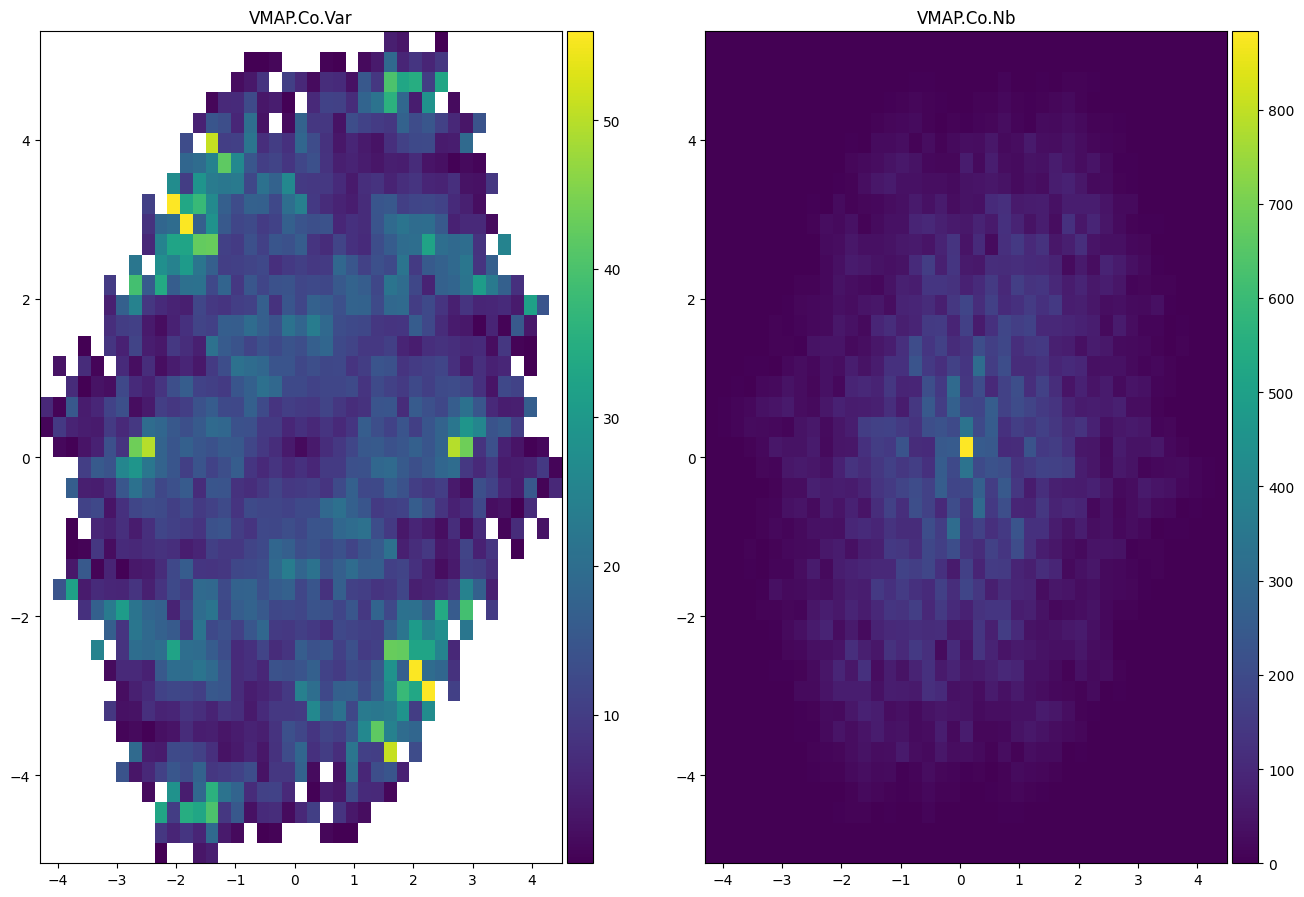

In [59]:
## Compute variogram map
grid_vmap = mg.vario_map(db_jura, "Co", 20)
import matplotlib.pyplot as plt

## Plot (Left: Variogram map, Right: Number of pairs used to compute each value)
fig, ax = plt.subplots(1, 2, figsize=[14, 10])
fig.tight_layout(pad=5.0)
ax[0].raster(grid_vmap, flagLegend=True)
ax[1].raster(grid_vmap, name="*Nb", flagLegend=True)
plt.show()

Much like their isotropic counterparts, experimental directional variograms are computed as Vario objects, which can be created from he VarioParam object (containing the parameters of the variogram) and a Db containing the data points.

This time, the VarioParam object is created using the function VarioParam_createMultiple. There, we specify the number K of directions θ for which we wish to compute the an experimental variogram (argument ndir), as well as the reference angle θ of the first direction (argument angref, default = 0) so that the directions θ+i(180/K) for i=0,...,K−1 are considered. We can also specify the number of lags h for which the experimental variogram is computed (argument npas), and the distance between these lags (argument npas), as well as the tolerance τ on the lags (argument toldis).

In the following example, we create an experimental variogram in the 4 directions θ=0∘,45∘,90∘,135∘.

In [60]:
## Create experimental variogram parametrization:
vario_4dir = mg.vario_exp(
    db_jura, vname="Co", dir=[0, 45, 90, 135], nlag=30, dlag=0.1, toldis=0.5
)

 Then, the experimental variogram is computed just as in the isotropic case.


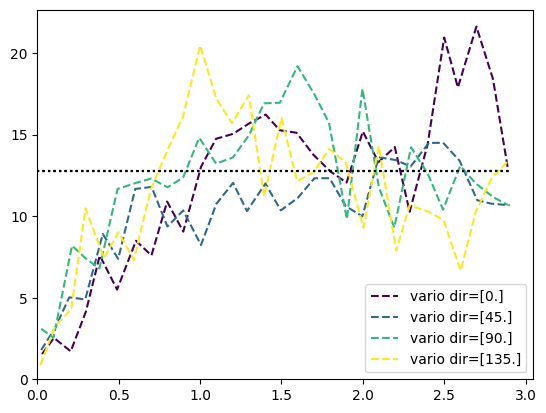

In [61]:
## Plot
ax = gp.varmod(vario_4dir, flagLegend=True)

Then, fitting a model onto the resulting experimental variogram is done using the same commands as in the isotropic case.

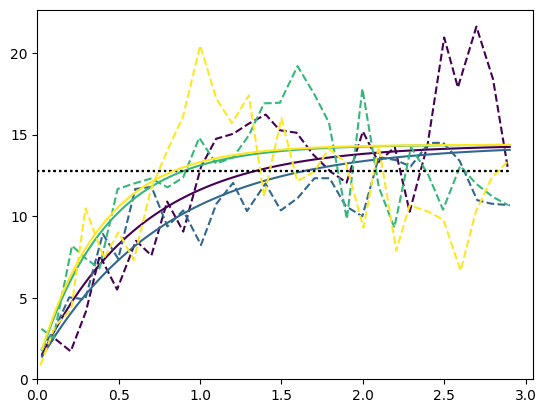

In [62]:
## Create Model object and fit the experimental variogram
model_4dir = mg.model_fit(vario_4dir, ["NUGGET", "EXPONENTIAL"])
## Plot
ax = gp.varmod(vario_4dir, model_4dir)

In [66]:
varioexp.getAllSw()
# gp.plot(varioexp,showPairs=True)

array([ 193.,  155.,  249.,  414.,  644.,  692.,  538.,  755.,  916.,
        709.,  931., 1315.,  810., 1262., 1107., 1291., 1093., 1093.,
       1370.,  971., 1025., 1186., 1047.,  854.,  980., 1009.,  943.,
        847.,  898., 1022.])